# CAPSTONE

## Part 1: Getting Started

In [1]:
import json
import os
import pandas as pd
import re as re
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
from datetime import timedelta
import sklearn.metrics
import math


In [2]:
import warnings
warnings.filterwarnings("ignore")

### Download files

Notes:
The JSON files may not contain uniformly named features. 
Be sure to account for this in your data ingestion function.

Some of the invoice ids (invoice) have letters that 
can be removed to improve matching.

One common way to ready time-series data for modeling 
is to aggregate the transactions by day. Getting the data into this form will help you prepare for part 2.

If you have not worked with time-series or time-stamped 
data before the following two links can be useful.

#### List of input files

In [3]:
current_path='C:\\Users\\ERICMenguy\\Documents\\AIAcademy\\Part B\\AI in Production\\ai-workflow-capstone-master'
os.chdir(current_path)

DATA_DIR=os.path.join(current_path,"data")

##### Note: The JSON files may not contain uniformly named features. Be sure to account for this in your data ingestion function.

In [4]:
column_names = ["country","customer_id","invoice","price","stream_id","times_viewed","year","month","day"]
df = pd.DataFrame(columns = column_names)
list_files = os.listdir(DATA_DIR)

for file in list_files:
    with open(os.path.join(DATA_DIR,file)) as f:
        data = json.load(f)
        #print(data)
        df_new = pd.DataFrame(data)
        actual_column_names=list(df_new.columns.values)
        for k in range(len(actual_column_names)):
            df_new.rename(columns={actual_column_names[k]: column_names[k]}, inplace=True)       
        df_new.head()
        df = df.append(df_new,ignore_index = True)
      
df.head(10)

,country,customer_id,invoice,price,stream_id,times_viewed,year,month,day
0,United Kingdom,13085.0,489434,6.95,85048,12,2017,11,28
1,United Kingdom,NaN,489597,8.65,22130,1,2017,11,28
2,United Kingdom,NaN,489597,1.70,22132,6,2017,11,28
3,United Kingdom,NaN,489597,1.70,22133,4,2017,11,28
4,United Kingdom,NaN,489597,0.87,22134,1,2017,11,28
5,United Kingdom,NaN,489597,0.87,22135,1,2017,11,28
6,United Kingdom,NaN,489597,11.26,22138,3,2017,11,28
7,United Kingdom,NaN,489597,11.26,22139,2,2017,11,28
8,United Kingdom,NaN,489597,4.30,22141,6,2017,11,28
9,United Kingdom,NaN,489597,3.43,22142,2,2017,11,28


### First observations

In [5]:
## Number of countries
print(df.country.unique())

## top 10 countries in terms of revenue
df_country = pd.pivot_table(df, index= ['country'], values=['price'],aggfunc='sum').round(3)
df_country.reset_index(inplace=True)
df_country.sort_values(by=['price'],ascending = False,inplace = True)

print(df_country.head(10))

total_price = df_country['price'].sum()
print(total_price)
df_country['contribution']=100*(df_country['price']/total_price)

list_countries = df_country['country'].tolist()
print('list of countries :',list_countries)

top_10_countries = df_country['country'].iloc[0:9].tolist()
print('top 10 countries :',top_10_countries)

['United Kingdom' 'Portugal' 'Germany' 'EIRE' 'France' 'USA' 'Australia'
 'Belgium' 'Netherlands' 'Nigeria' 'Japan' 'Denmark' 'Poland' 'Spain'
 'Italy' 'Channel Islands' 'Cyprus' 'Norway' 'Greece' 'Austria' 'Sweden'
 'United Arab Emirates' 'Finland' 'Switzerland' 'Unspecified' 'Malta'
 'Bahrain' 'RSA' 'Bermuda' 'Hong Kong' 'Singapore' 'Thailand' 'Israel'
 'Lithuania' 'West Indies' 'Lebanon' 'Korea' 'Brazil' 'Canada' 'Iceland'
 'Saudi Arabia' 'Czech Republic' 'European Community']
           country        price
40  United Kingdom  3521513.505
11            EIRE   107069.210
15         Germany    49271.821
14          France    40565.140
28          Norway    38494.750
34           Spain    16040.990
17       Hong Kong    14452.570
30        Portugal    13528.670
33       Singapore    13175.920
26     Netherlands    12322.800
3914197.366
list of countries : ['United Kingdom', 'EIRE', 'Germany', 'France', 'Norway', 'Spain', 'Hong Kong', 'Portugal', 'Singapore', 'Netherlands', 'Belgium', 

#### Missing values 

In [6]:
## missing values summary
print("Missing Value Summary\n{}".format("-"*35))
print(df.isnull().sum(axis = 0))

df.size
print('pct_missing_customer_id :' , 100*(df['customer_id'].isnull().sum() / df.size))

Missing Value Summary
-----------------------------------
country              0
customer_id     189762
invoice              0
price                0
stream_id            0
times_viewed         0
year                 0
month                0
day                  0
dtype: int64
pct_missing_customer_id : 2.5870407475072934


#### Some of the invoice ids (invoice) have letters that can be removed to improve matching.

In [7]:
def find_number(text):
    num = re.findall(r'[0-9]+',text)
    return " ".join(num)

df['invoice']=df['invoice'].apply(lambda x: find_number(x))

In [8]:
## convert times_viewed to numeric

df['times_viewed'] = pd.to_numeric(df['times_viewed'], errors='coerce')
df['month'] = pd.to_numeric(df['month'], errors='coerce')
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df['day'] = pd.to_numeric(df['day'], errors='coerce')

In [9]:
## Distribution of times_viewed and price
print('distribution of times_viewed',df['times_viewed'].describe())
print('distribution of price',df['price'].describe())

distribution of times_viewed count    815011.000000
mean          5.231106
std           5.109982
min           0.000000
25%           1.000000
50%           3.000000
75%           8.000000
max          24.000000
Name: times_viewed, dtype: float64
distribution of price count    815011.000000
mean          4.802631
std         135.058707
min      -53594.360000
25%           1.250000
50%           2.100000
75%           4.210000
max       38970.000000
Name: price, dtype: float64


In [10]:
## Replace negative values of price by 0

df.loc[df['price'] < 0] = 0

print('distribution of price after excluding negative values' ,df['price'].describe())

distribution of price after excluding negative values count    815011.000000
mean          4.970178
std         102.356661
min           0.000000
25%           1.250000
50%           2.100000
75%           4.210000
max       38970.000000
Name: price, dtype: float64


In [11]:
df=df.loc[df['year'] > 0]

## Monthly aggregation

In [12]:
## Prepare data to get the number of purchase. A purchases are identified by invoice id

df1=pd.pivot_table(df, index=['country','invoice','year','month','day'], 
                                 values=['price','times_viewed'],
                                 aggfunc='sum').round(1)
df1['purchase'] = 1
df1.reset_index(inplace=True)
df1['day']=1
df1['date'] = pd.to_datetime(df1[['year', 'month','day']])

df1.head()

,country,invoice,year,month,day,price,times_viewed,purchase,date
0,Australia,489449,2017,11,1,20.2,20,1,2017-11-01
1,Australia,489450,2017,11,1,20.2,77,1,2017-11-01
2,Australia,490702,2017,12,1,10.1,4,1,2017-12-01
3,Australia,490756,2017,12,1,2.5,5,1,2017-12-01
4,Australia,492744,2017,12,1,6.6,40,1,2017-12-01


In [13]:
# Monthly aggregation - Aggregagtion by country 

## Add missing dates

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)
        
list_country_0 = []
for f in list_countries:
    for d in daterange(df1.date.min(),df1.date.max()):
        list_country_0.append([f,d,0,0,0])

df_01 = pd.DataFrame(list_country_0, columns=["country", "date","price","times_viewed","purchase"])
df_01.sort_values(by=['country','date'],ascending = True,inplace = True)

## concatenate
df_02 = pd.concat([df1,df_01])
df_02.sort_values(by=['country','date'],ascending = True,inplace = True)
df_02.head(33)


## Aggregate again
df_03=pd.pivot_table(df_02, index=['country','date'], 
                                 values=['price','times_viewed','purchase'],
                                 aggfunc='sum').round(1)
df_03.reset_index(inplace=True)
df_03['year'] = df_03['date'].dt.year
df_03['month'] = df_03['date'].dt.month

## Aggregation at monthly level

df_country=pd.pivot_table(df_03, index=['country','year','month'], 
                                 values=['price','times_viewed','purchase'],
                                 aggfunc='sum').round(1)

df_country['day'] = 1
df_country.reset_index(inplace=True)
df_country['date'] = pd.to_datetime(df_country[['year', 'month','day']])
df_country.drop(columns=['year','month','day'],inplace=True)

print(df_country.head())


     country  price  purchase  times_viewed       date
0  Australia   40.4         2            97 2017-11-01
1  Australia   19.2         3            49 2017-12-01
2  Australia    0.0         0             0 2018-01-01
3  Australia   60.2         3           350 2018-02-01
4  Australia   54.6         2           160 2018-03-01


        date     price  purchase  times_viewed
0 2017-11-01   41153.6       449         44972
1 2017-12-01  157159.8      1881        165047
2 2018-01-01  183680.7      1925        176494
3 2018-02-01  116349.8      1995        157529
4 2018-03-01  257432.1      2162        201318


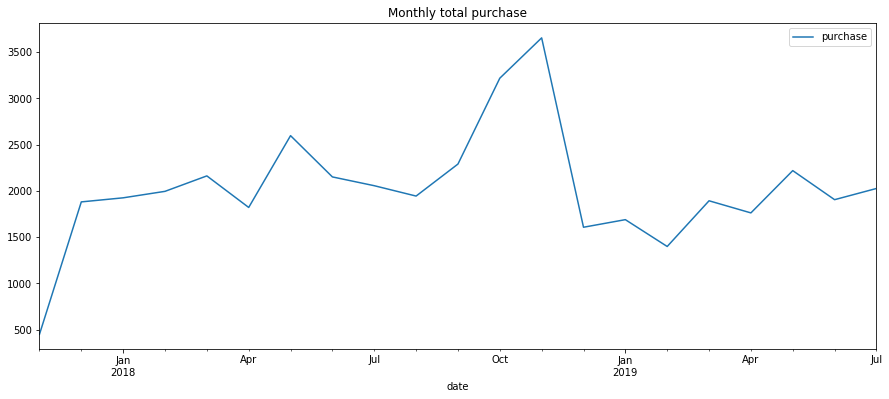

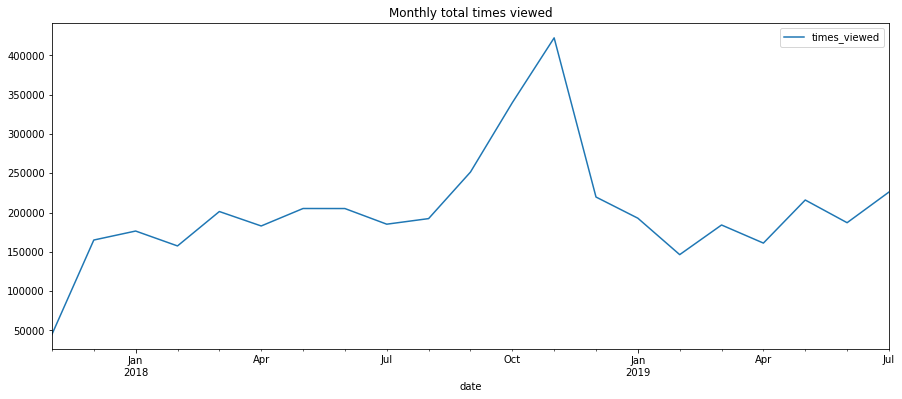

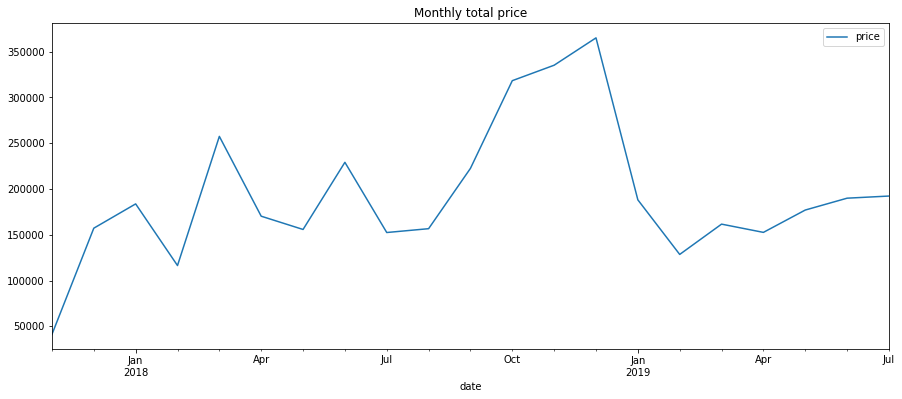

In [14]:
## Monthly aggregation
## Aggregation "all countries"

df_all_countries = pd.pivot_table(df_country, index=['date'], 
                     values=["price","times_viewed","purchase"],
                     aggfunc='sum').round(2)
df_all_countries.reset_index(inplace = True)
print(df_all_countries.head())


df_all_countries.plot('date','purchase',figsize=(15, 6))
plt.title('Monthly total purchase')
plt.show()

df_all_countries.plot('date','times_viewed',figsize=(15, 6))
plt.title('Monthly total times viewed')
plt.show()

df_all_countries.plot('date','price',figsize=(15, 6))
plt.title('Monthly total price')
plt.show()

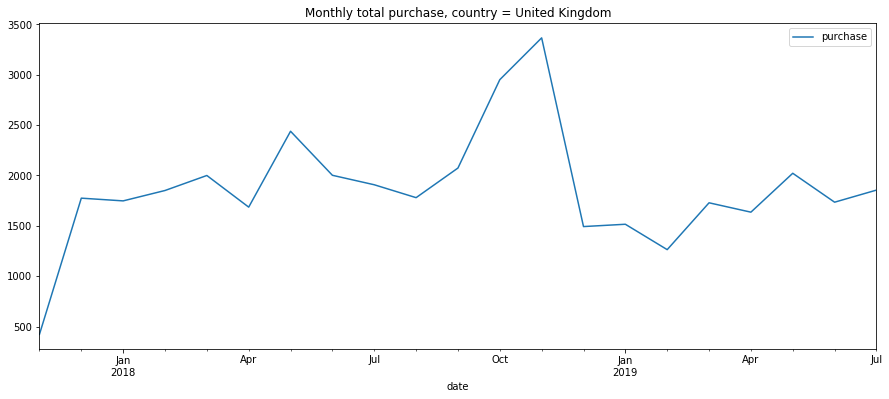

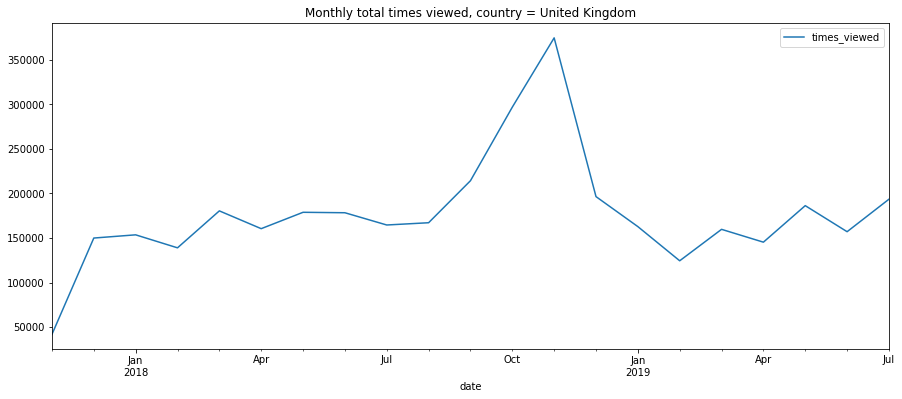

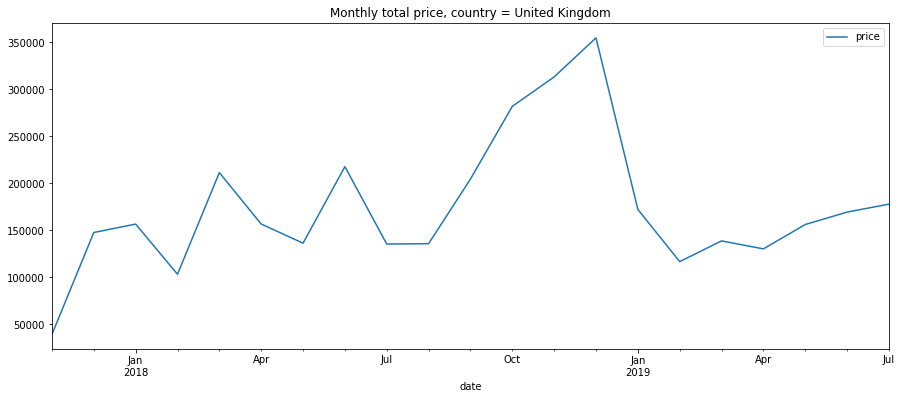

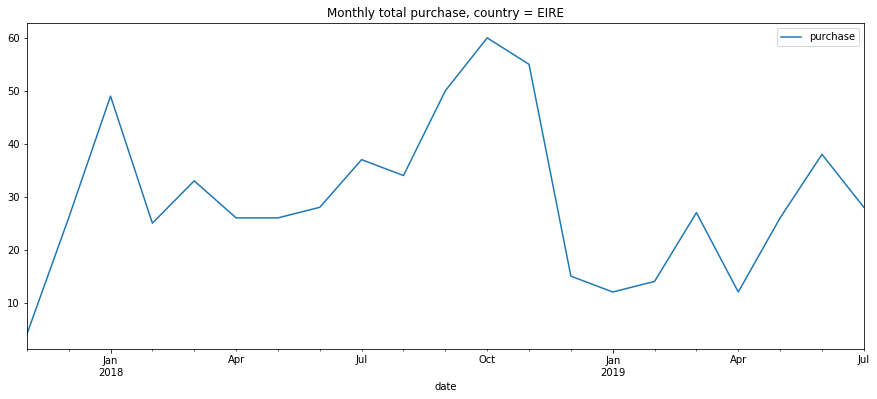

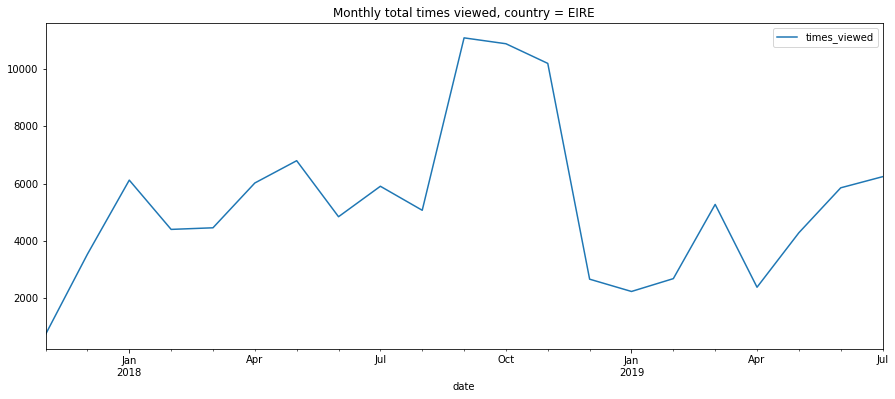

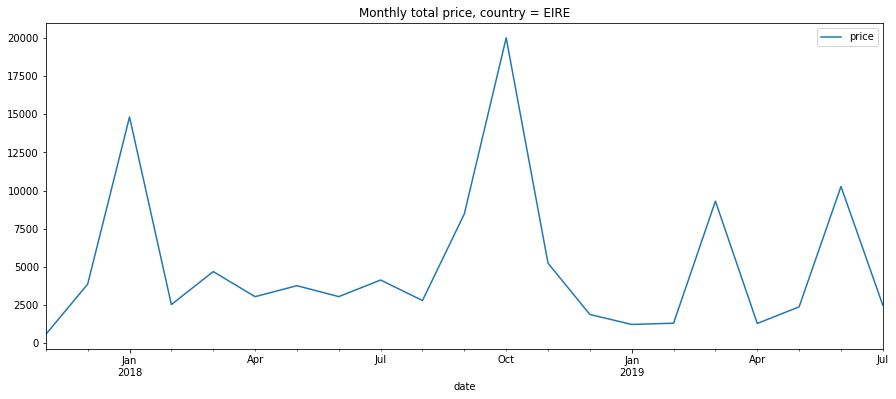

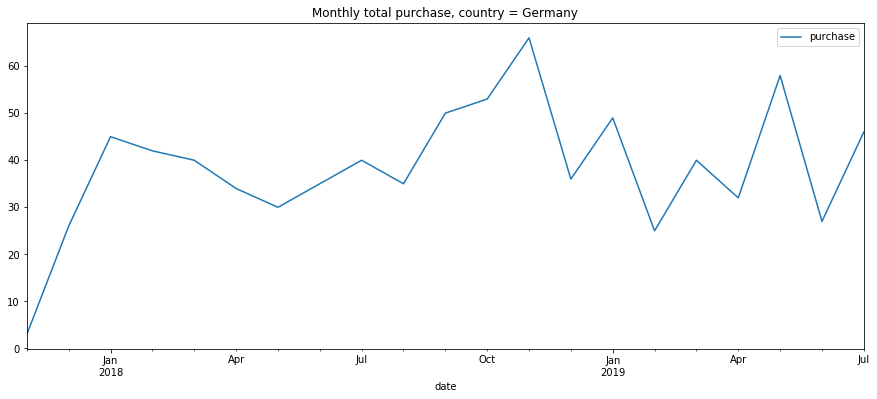

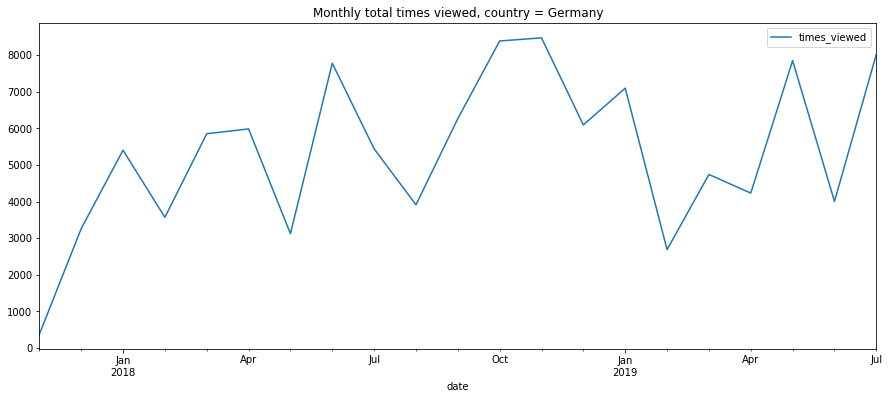

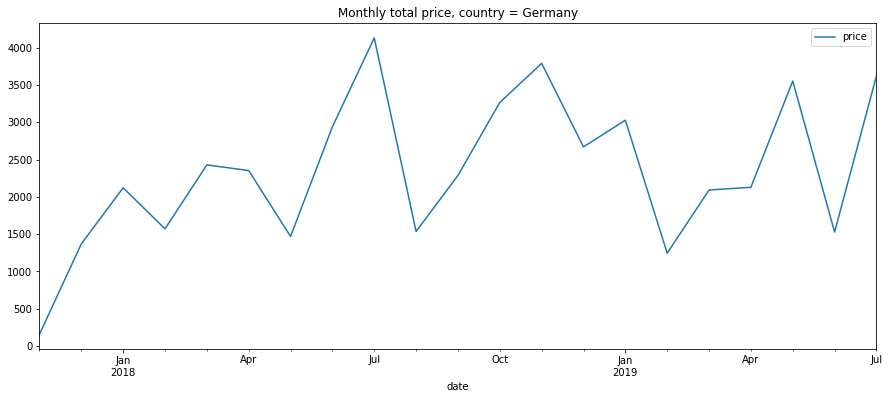

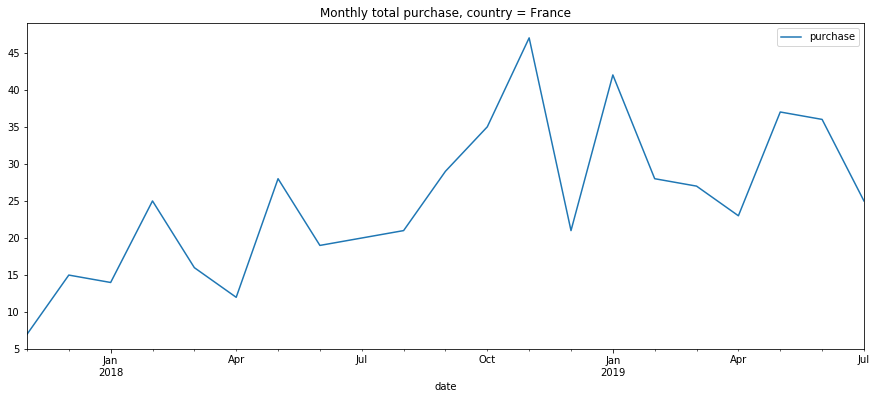

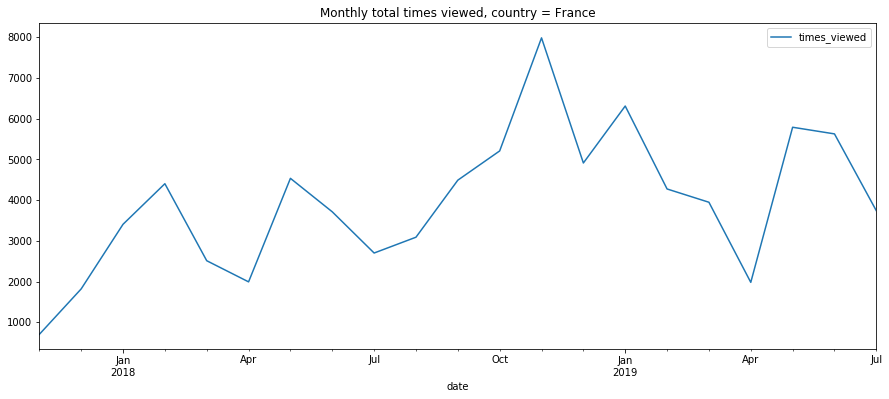

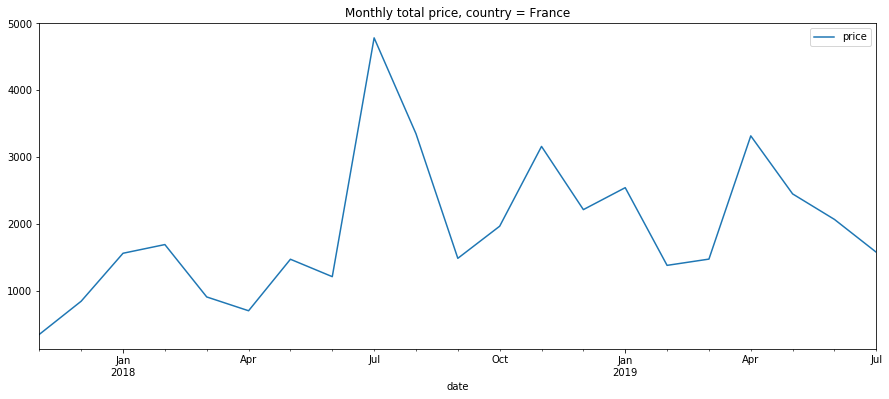

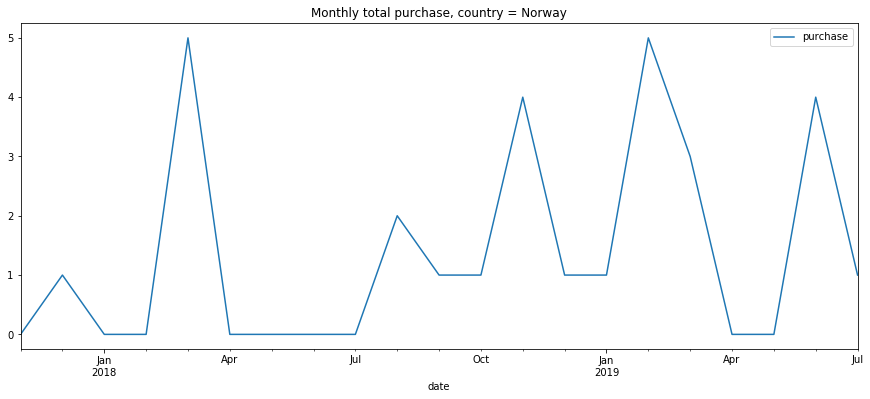

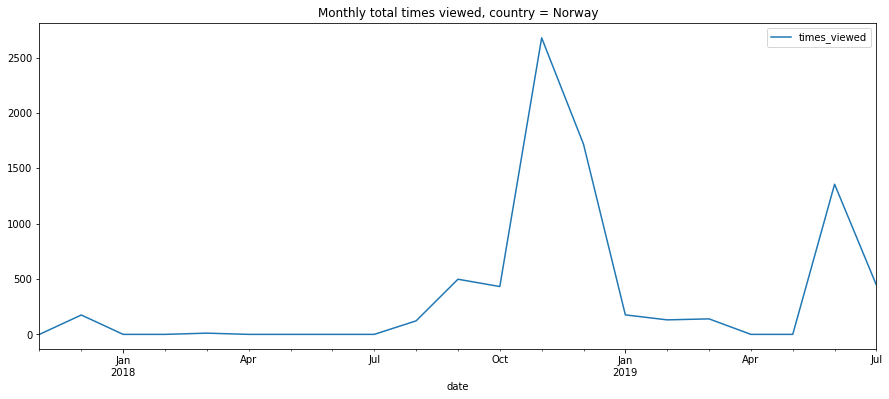

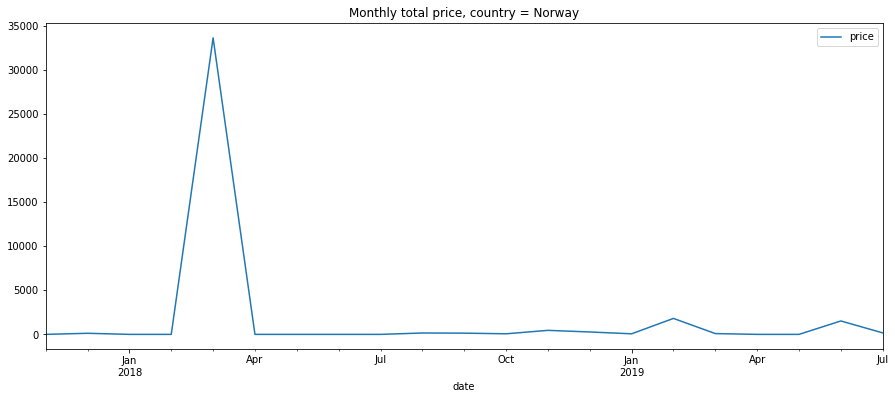

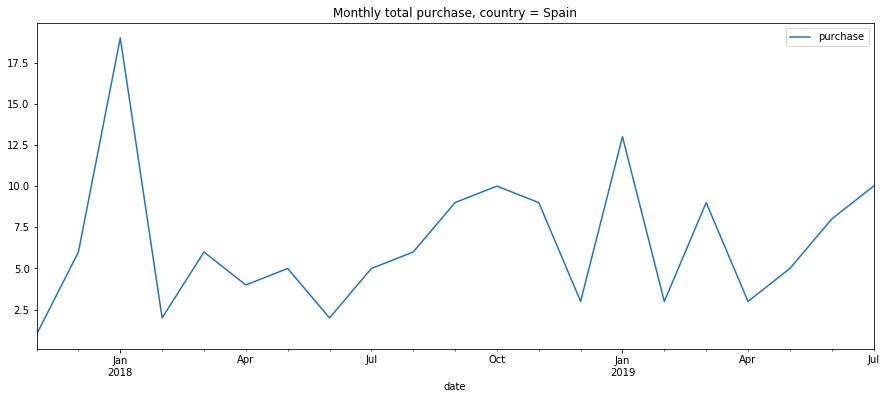

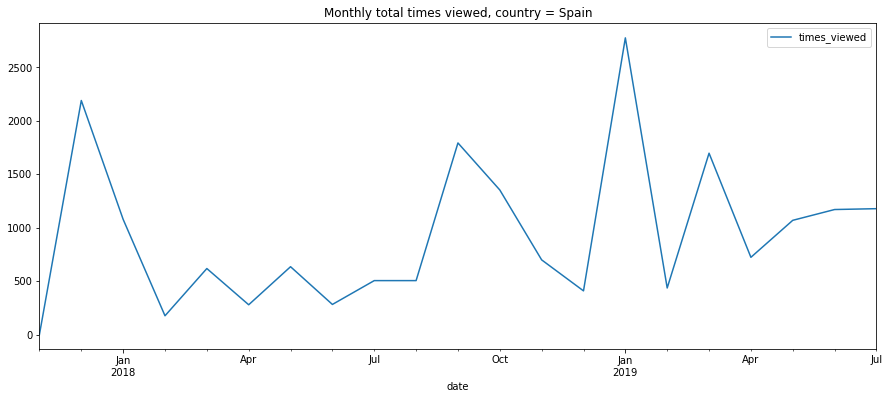

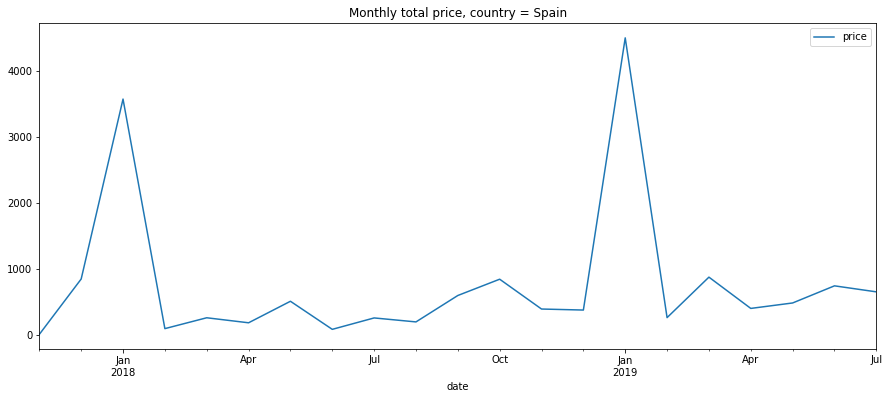

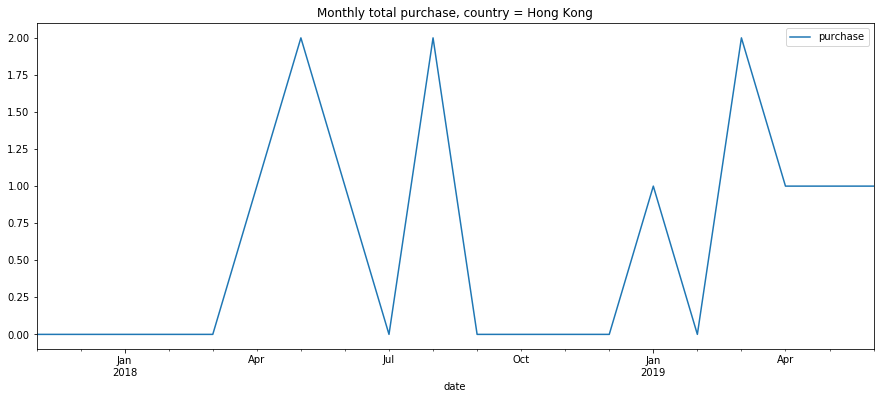

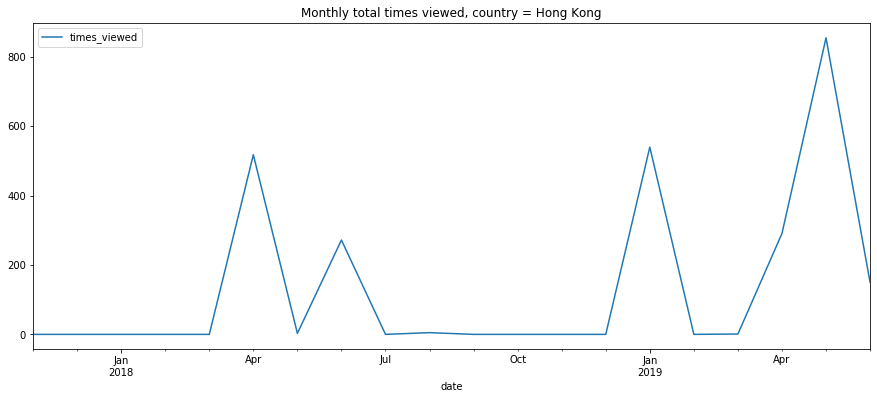

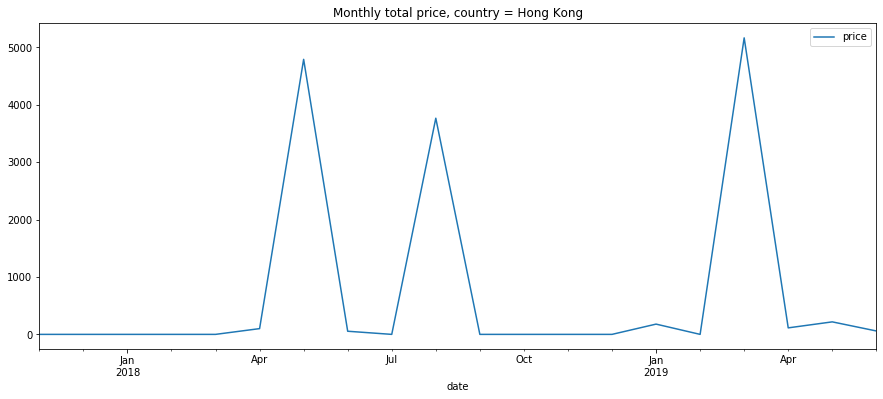

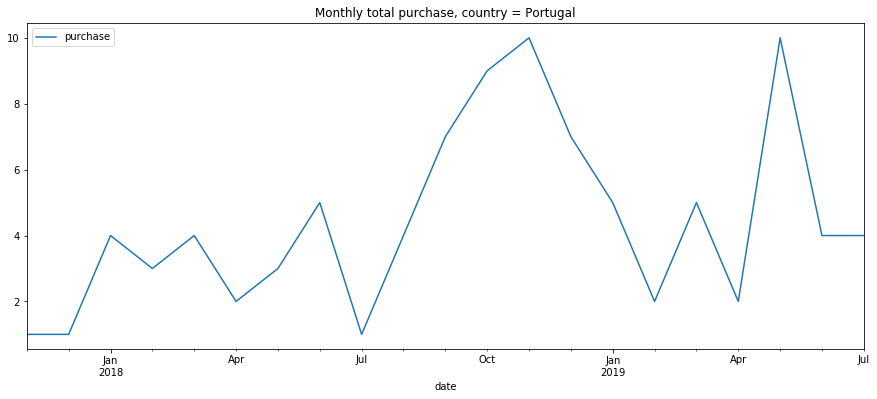

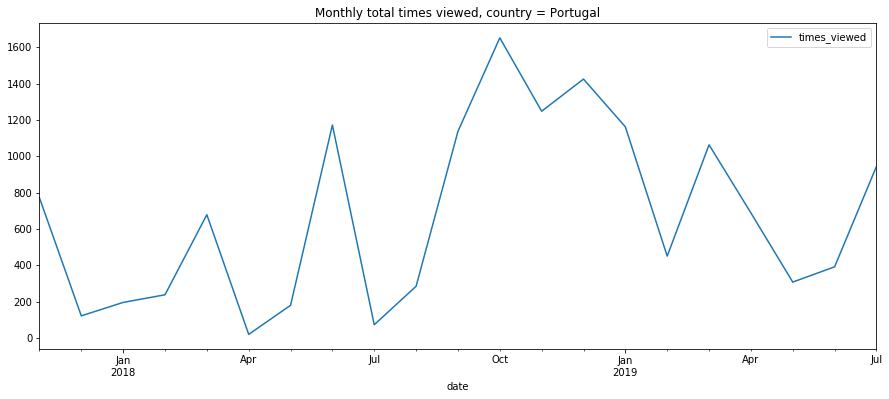

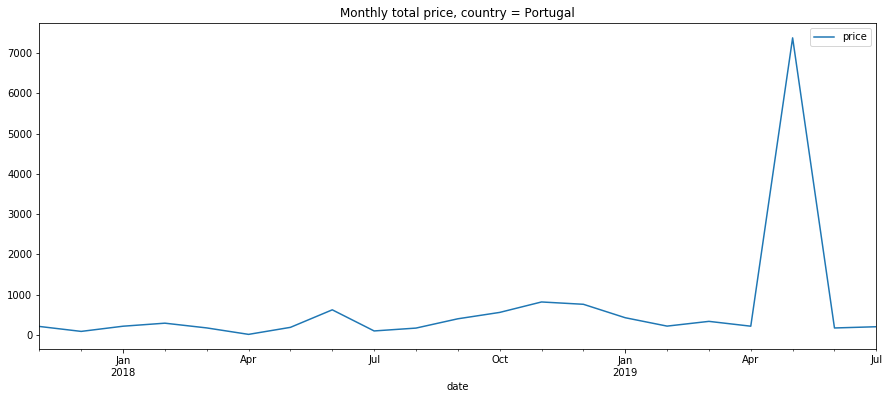

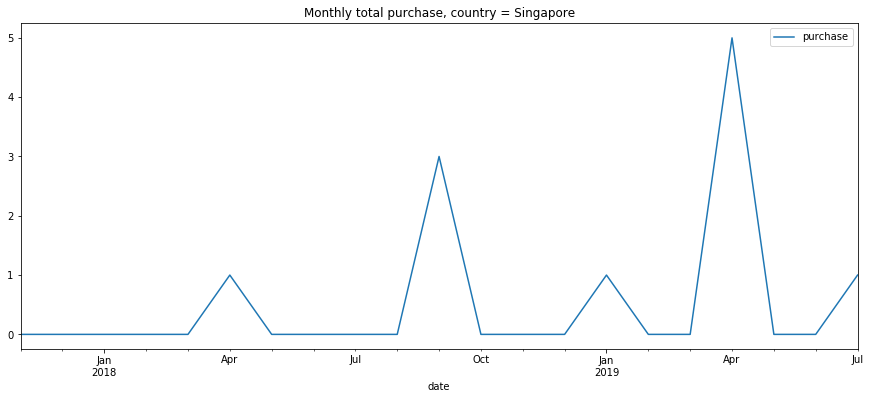

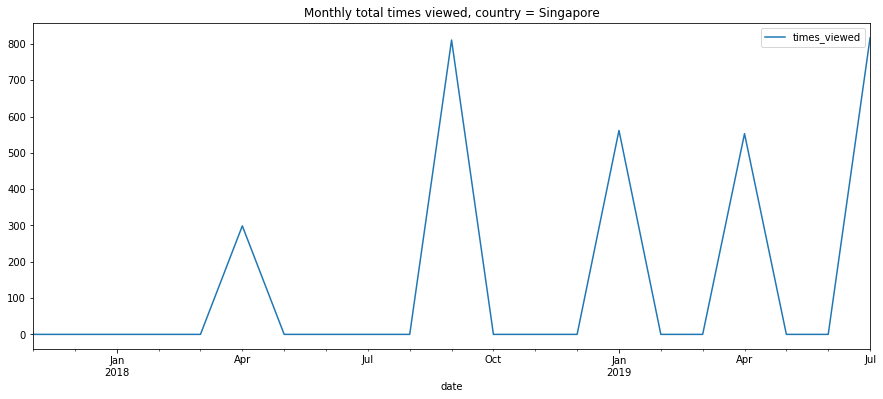

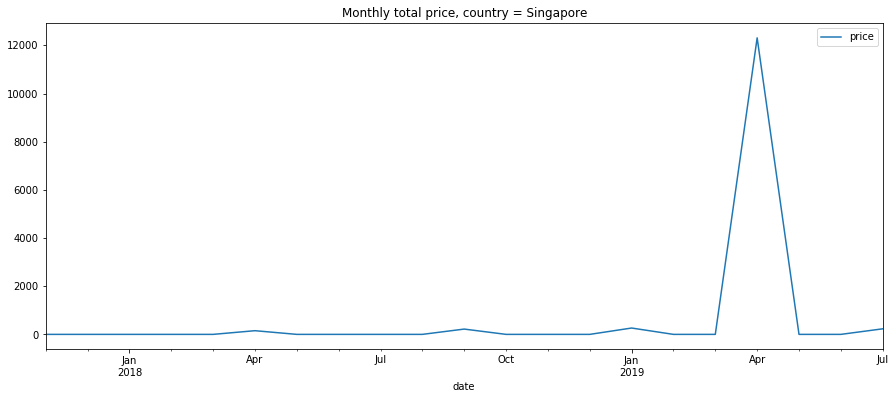

In [15]:
## Focus on top 10 countries

for f in top_10_countries:
    series=df_country[df_country['country']==f]
    
    series.plot('date','purchase',figsize=(15, 6))
    plt.title('Monthly total purchase, country = ' + f)
    plt.show()

    series.plot('date','times_viewed',figsize=(15, 6))
    plt.title('Monthly total times viewed, country = ' + f)
    plt.show()

    series.plot('date','price',figsize=(15, 6))
    plt.title('Monthly total price, country = ' + f)
    plt.show()


## Creation of time series for modeling

In [16]:
import datetime

## Times series: all countries
ts_all_countries = df_all_countries.set_index('date')
print(ts_all_countries.head())


## Time series: by country
ts_country = df_country.set_index('date')
print(ts_country.head())

               price  purchase  times_viewed
date                                        
2017-11-01   41153.6       449         44972
2017-12-01  157159.8      1881        165047
2018-01-01  183680.7      1925        176494
2018-02-01  116349.8      1995        157529
2018-03-01  257432.1      2162        201318
              country  price  purchase  times_viewed
date                                                
2017-11-01  Australia   40.4         2            97
2017-12-01  Australia   19.2         3            49
2018-01-01  Australia    0.0         0             0
2018-02-01  Australia   60.2         3           350
2018-03-01  Australia   54.6         2           160


###  Detailed analysis is performed on revenue « all countries »

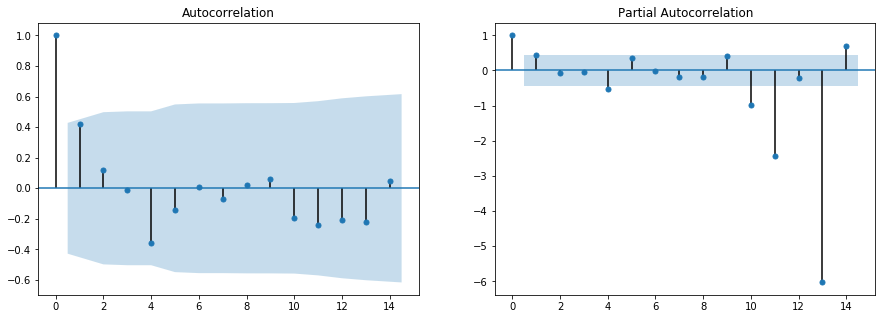

In [17]:
## Acf and pacf

import statsmodels

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

figsize=(15,15)

pyplot.figure(figsize=(15,5))
pyplot.subplot(1,2,1)
plot_acf(ts_all_countries['price'], ax=pyplot.gca())
pyplot.subplot(122)

plot_pacf(ts_all_countries['price'], ax=pyplot.gca())
pyplot.show()

In [18]:
## Observations
# The ACF shows a significant lag for 1 month.
# The PACF shows a significant lag for 1 months
# Both the ACF and PACF show a drop-off at the same point, perhaps suggesting a mix of AR and MA.

# 12 months Seasonality observed on the PACF curve

# A good starting point for arma part is the p and q values is 1.

In [19]:
## Dicky-Fuller test
from statsmodels.tsa.stattools import adfuller
 
# check if stationary
result = adfuller(ts_all_countries['price'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))



ADF Statistic: -1.984164
p-value: 0.293559
Critical Values:
	1%: -4.138
	5%: -3.155
	10%: -2.714


In [20]:
## The Dickey-Fuller test has not rejected the null hypothesis that a unit root is present.

In [21]:
## Select revenue only

ts_all_countries_price=ts_all_countries[['price']]
print(ts_all_countries_price.head())

ts_country_price=ts_country[['country','price']]
print(ts_country_price.head())

               price
date                
2017-11-01   41153.6
2017-12-01  157159.8
2018-01-01  183680.7
2018-02-01  116349.8
2018-03-01  257432.1
              country  price
date                        
2017-11-01  Australia   40.4
2017-12-01  Australia   19.2
2018-01-01  Australia    0.0
2018-02-01  Australia   60.2
2018-03-01  Australia   54.6


### Multiple models comparison

In [22]:
p = range(0, 2)
q = range(0, 2)
d = range(0,2)

p_seas = range(0, 2)
q_seas = range(0, 2)
d_seas = range(0,2)
r_seas = range(12,13)

pdq = list(itertools.product(p, d, q))
pdq_seas = list(itertools.product(p_seas, d_seas, q_seas, r_seas))
x = {}
for param in pdq:
    for param_seas in pdq_seas:
        try:
            model = sm.tsa.statespace.SARIMAX(ts_all_countries_price,
                                                  order=param,
                                                  seasonal_order=(param_seas))
            result = model.fit()
            d = {(param,param_seas) : result.aic}
            x.update(d)
        except:
            continue

In [23]:
temp = min(x.values())
res = [key for key in x if x[key] == temp]
# printing result 
print("param with minimum values are : " + str(res))
print("aic minimum is : " + str(temp))

param with minimum values are : [((0, 1, 0), (1, 1, 0, 12))]
aic minimum is : 206.00039008233236


In [24]:
model = sm.tsa.statespace.SARIMAX(ts_all_countries_price,order=(0, 1, 0),seasonal_order=(1, 1, 0, 12))
result = model.fit()
print(result.summary().tables[1])

forecast = result.get_forecast(steps=6)
## equivalently :
# forecast = res.get_forecast('2020-01-01')
print(forecast.summary_frame())

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.8497      1.375     -0.618      0.536      -3.544       1.844
sigma2      8.747e+09   2.89e-10   3.03e+19      0.000    8.75e+09    8.75e+09
price                mean        mean_se  mean_ci_lower  mean_ci_upper
2019-08-01  192886.235867   93527.682511    9575.346588  376197.125145
2019-09-01  202789.107543  132268.117064  -56451.638205  462029.853291
2019-10-01  217184.051976  161994.698023 -100319.721835  534687.825787
2019-11-01  254691.015519  187055.365016 -111930.763028  621312.794066
2019-12-01  357755.247842  209132.529577  -52136.978125  767647.473809
2020-01-01  353706.521672  229091.947203  -95305.443994  802718.487337


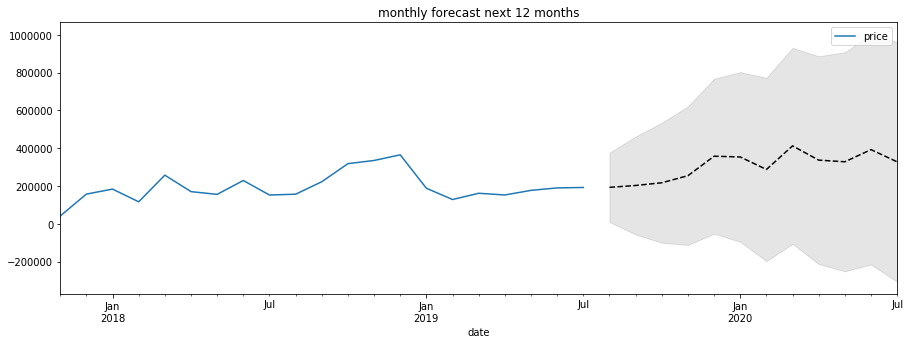

In [25]:
## Visualize forecasts

fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
ts_all_countries_price.loc['2017-07-01':].plot(ax=ax)

# Construct the forecasts (next year)
forecast = result.get_forecast(steps = 12).summary_frame()
forecast['mean'].plot(ax=ax, style='k--', title = 'monthly forecast next 12 months')
ax.fill_between(forecast.index, forecast['mean_ci_lower'], forecast['mean_ci_upper'], color='k', alpha=0.1);

## Baseline model and comparison to the targeted model

### Baseline model

In [26]:
## The baseline model is the first order model, that is forecasted value at a current date 
## is the the value at the previous month

model_base = sm.tsa.statespace.SARIMAX(ts_all_countries_price,order=(0,1,0))
result_base = model_base.fit()

#aic_base = result_base.aic
print('aic basic model :', result_base.aic)

aic basic model : 507.1946580834955


### Compare forecasts between basic model and final model on the 4 next months

In [29]:

forecast_base = result_base.get_forecast(steps=4)
forecast = result.get_forecast(steps=4)

df_forecast=forecast.summary_frame()
df_forecast.reset_index(inplace=True)
df_forecast=df_forecast[['index','mean']]
df_forecast.rename(columns={'mean':'forecast', 'index':'date'},inplace=True)

df_forecast_base=forecast_base.summary_frame()
df_forecast_base.reset_index(inplace=True)
df_forecast_base=df_forecast_base[['index','mean']]
df_forecast_base.rename(columns={'mean':'forecast_base', 'index':'date'},inplace=True)

# merge the 2 dataset
compare = pd.merge(df_forecast,df_forecast_base,on=['date'])


# add observed test data: the function load_invoices_data() in the notebook Capstone - download invoices 
#is used to get this data
#data is tored in the file Capstone - download invoices.csv

observed_data = pd.read_csv("invoices_production.csv")
observed_data = observed_data[['date','price']]
compare['observed'] = observed_data['price']
compare.dropna(inplace=True)


#print(compare.head())

## Compute rmse beeween base model and final model
mse_base = sklearn.metrics.mean_squared_error(compare['forecast_base'], compare['observed'])
rmse_base = math. sqrt(mse_base)
print('root mean square error between base model observed revenue', rmse_base)


mse = sklearn.metrics.mean_squared_error(compare['forecast'], compare['observed'])
rmse = math. sqrt(mse)
print('root mean square error between model and observed revenue', rmse)


root mean square error between base model observed revenue 78645.93494876262
root mean square error between model and observed revenue 246466.7843159118


## Modeling and Forecasting by Country

In [28]:
# Modeling by country
p = range(0, 2)
q = range(0, 2)
d = range(0,2)

p_seas = range(0, 2)
q_seas = range(0, 2)
d_seas = range(0,2)
r_seas = range(12,13)

pdq = list(itertools.product(p, d, q))
pdq_seas = list(itertools.product(p_seas, d_seas, q_seas, r_seas))


for country in top_10_countries:
    x = {}
    series = ts_country_price.loc[ts_country_price['country']==country]
    series.drop(columns=['country'],inplace = True)
    for param in pdq:
        for param_seas in pdq_seas:
            try:
                model = sm.tsa.statespace.SARIMAX(series,
                                            order=param,
                                            seasonal_order=(param_seas), missing = 'none')
                result = model.fit()
                d = {(param,param_seas) : result.aic}
                x.update(d)
            except:
                continue
        
    temp = min(x.values())
    res = [key for key in x if x[key] == temp]
  
    #printing result 
    print('country : ', country)
    print("param with minimum values are : " + str(res))
    print("aic minimum is : " + str(temp))      
    
    mod = sm.tsa.statespace.SARIMAX(series,order=res[0][0],seasonal_order=res[0][1])
    result = mod.fit()
    print(result.forecast())


country :  United Kingdom
param with minimum values are : [((0, 1, 0), (1, 1, 0, 12))]
aic minimum is : 205.60948679787947
2019-08-01    178040.254724
Freq: MS, dtype: float64
country :  EIRE
param with minimum values are : [((0, 1, 0), (1, 1, 0, 12))]
aic minimum is : 165.22954582432592
2019-08-01    2479.899158
Freq: MS, dtype: float64
country :  Germany
param with minimum values are : [((1, 1, 0), (1, 1, 0, 12))]
aic minimum is : 138.08249278576722
2019-08-01    2424.46453
Freq: MS, dtype: float64
country :  France
param with minimum values are : [((0, 1, 0), (1, 1, 0, 12))]
aic minimum is : 136.1356241444445
2019-08-01    1578.460941
Freq: MS, dtype: float64
country :  Norway
param with minimum values are : [((0, 1, 0), (1, 1, 0, 12))]
aic minimum is : 139.19391407075568
2019-08-01    168.600015
Freq: MS, dtype: float64
country :  Spain
param with minimum values are : [((0, 1, 1), (1, 1, 0, 12))]
aic minimum is : 124.21895786308406
2019-08-01    489.118604
Freq: MS, dtype: float64
